In [67]:
#linear regression
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.metrics import mean_squared_error as mse
import geopy.distance
from sklearn.metrics import r2_score

df = pd.read_csv('nyc_taxi_trip_duration Dataset.csv')
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)

# Converting yes/no flag to 1 and 0
df['store_and_fwd_flag'] = 1 * (df.store_and_fwd_flag.values == 'Y')

df['log_trip_duration'] = np.log(df['trip_duration'].values + 1)

df['day_of_week'] = df['pickup_datetime'].dt.weekday
df['hour_of_day'] = df['pickup_datetime'].dt.hour

#short_distance
from geopy.distance import geodesic,great_circle
list1=[]
for i in range(0,df.shape[0]):
    coords_1 = (df["pickup_latitude"][i],df["pickup_longitude"][i])
    coords_2 = (df['dropoff_latitude'][i],df["dropoff_longitude"][i])
    c=great_circle(coords_1,coords_2).km
    list1.append(c)
df["Short_distance"]=list1    

#removing outliers
df=df[df["trip_duration"]<6000]
df = df.loc[(df.pickup_latitude > 40.6) & (df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
df.drop(["id","pickup_datetime","dropoff_datetime","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","store_and_fwd_flag"],axis=1,inplace=True)

#binning of target continous variable
from matplotlib import *
bins=np.linspace(min(df["log_trip_duration"]),max(df["log_trip_duration"]),201)  #for n equal bins we use n+1 dividers.therfore 4 dividers.
group_names=list(range(0,200))
df["log_binned"]=pd.cut(df["log_trip_duration"],bins,labels=group_names,include_lowest=True)   #new column=cut(column,bins,labels,include_lowest)

#Stratify sample
df=df.groupby('log_binned', group_keys=False).apply(lambda x: x.sample(frac=0.4,random_state=123))
#df=df.sample(n=85000,random_state=321)

#TRAIN and ERROR
x = df.drop(['trip_duration','log_trip_duration','log_binned'], axis=1)
y = df['trip_duration']
train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.2,random_state=120)

from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error as mse
lr = LR(normalize=True)
# Fitting the model
lr.fit(train_x, train_y)
# Predicting over the Train Set and calculating error
train_predict = lr.predict(train_x)
k = mse(train_predict, train_y)
print('Training Mean Squared Error', k )
test_predict = lr.predict(test_x)
k = mse(test_predict, test_y)
print('Test Mean squared Error    ', k )

Training Mean Squared Error 165526.95545574778
Test Mean squared Error     164932.2120535138


In [68]:
#Regularisation:Ridge
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
from numpy import arange

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
model = RidgeCV(alphas=arange(0, 1, 0.01), cv=cv, scoring='neg_mean_absolute_error')
model.fit(train_x, train_y)
#print(model.alpha_)
#ridgereg = Ridge(alpha=0.01,normalize=True)

train_y_pred = model.predict(train_x)
test_y_pred = model.predict(test_x)

mse_train = mse(train_y_pred,train_y)
print('Ridge Regularised Training Mean Squared Error',mse_train)
mse_test = mse(test_y_pred,test_y)
print('Ridge Regularised Test Mean squared Error    ',mse_test)


Ridge Regularised Training Mean Squared Error 165526.95545574778
Ridge Regularised Test Mean squared Error     164932.2120535138


In [69]:
#Regularisation:Lasso
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from numpy import arange

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
lassoreg = LassoCV(alphas=arange(0, 1, 0.01), cv=cv)
lassoreg.fit(train_x,train_y)
train_y_pred = lassoreg.predict(train_x)
test_y_pred = lassoreg.predict(test_x)

mse_train = mse(train_y_pred,train_y)
print('Lasso Regularised Training Mean Squared Error',mse_train)
mse_test = mse(test_y_pred,test_y)
print('Lasso Regularised Test Mean squared Error    ',mse_test)

Lasso Regularised Training Mean Squared Error 165527.27292204916
Lasso Regularised Test Mean squared Error     164931.97712941736


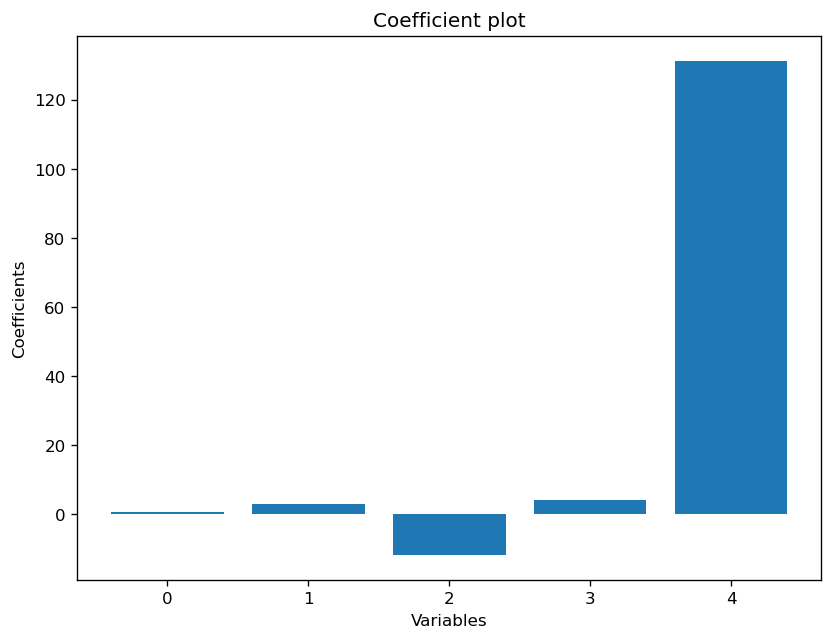

Index(['vendor_id', 'passenger_count', 'day_of_week', 'hour_of_day',
       'Short_distance'],
      dtype='object')

In [70]:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='b')
x = range(len(train_x.columns))
y = lr.coef_
plt.bar( x, y )
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Coefficient plot')
plt.show()
train_x.columns

In [71]:
# Arranging and calculating the Residuals
residuals = pd.DataFrame({
    'fitted values' : test_y,
    'predicted values' : test_predict,
})

residuals['residuals'] = residuals['fitted values'] - residuals['predicted values']
residuals.head()

,fitted values,predicted values,residuals
714826,1139,681.757469,457.242531
629225,1005,1651.814619,-646.814619
403592,2183,3150.703794,-967.703794
616097,760,546.960351,213.039649
449663,237,590.664159,-353.664159


In [72]:
residuals.residuals[:]

714826    457.242531
629225   -646.814619
403592   -967.703794
616097    213.039649
449663   -353.664159
             ...    
304407   -162.692879
337278   -255.102712
712595   -200.206325
208883    766.849612
657325   -136.335364
Name: residuals, Length: 58000, dtype: float64

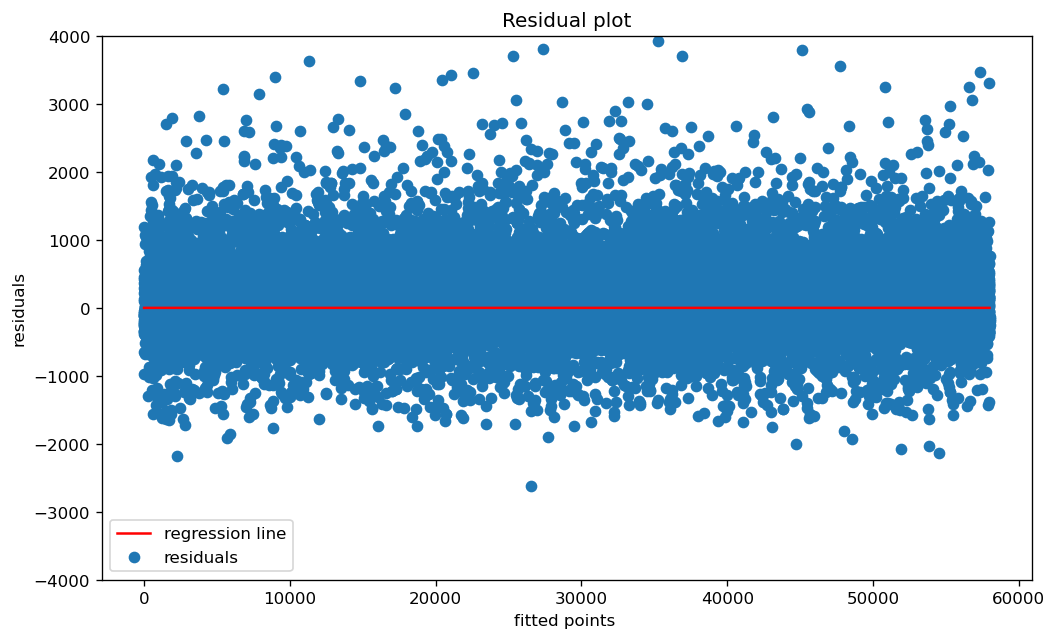

In [73]:
plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,58000)
k = [0 for i in range(0,58000)]
plt.scatter( f, residuals.residuals[:], label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.ylim(-4000, 4000)
plt.legend()

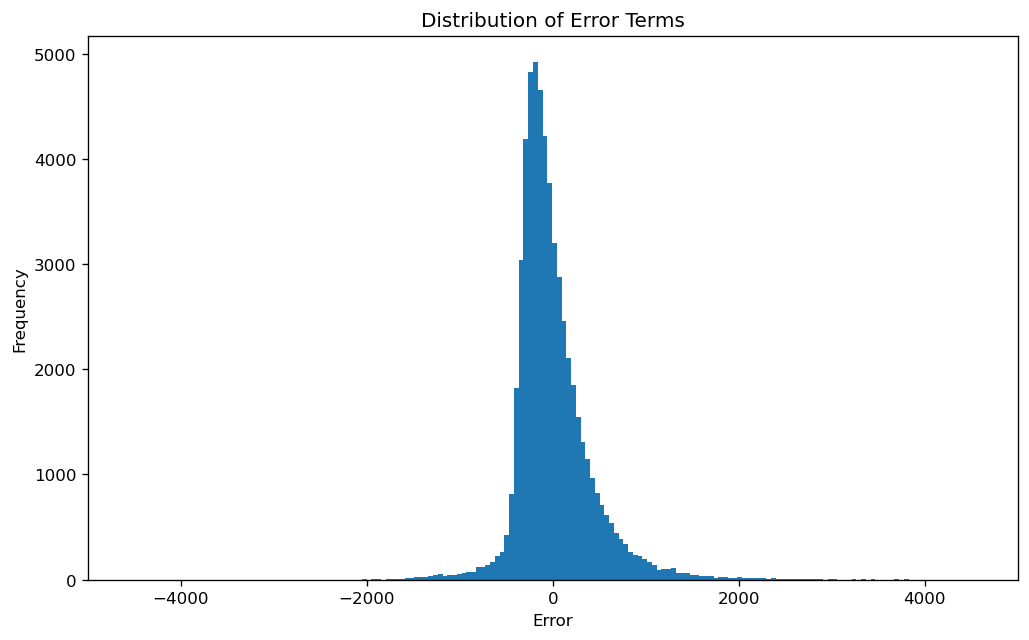

In [74]:
plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
plt.hist(residuals.residuals, bins = 150)
plt.xlim(-5000,5000)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Distribution of Error Terms')
plt.show()

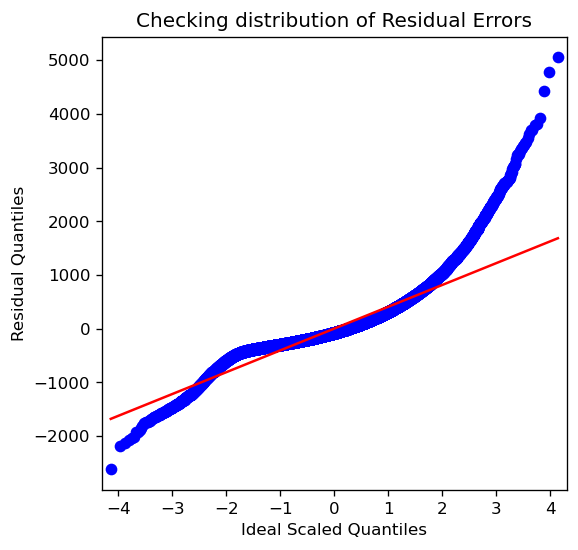

In [75]:
# importing the QQ-plot from the from the statsmodels
from statsmodels.graphics.gofplots import qqplot

## Plotting the QQ plot
fig, ax = plt.subplots(figsize=(5,5) , dpi = 120)
qqplot(residuals.residuals, line = 's' , ax = ax)
plt.ylabel('Residual Quantiles')
plt.xlabel('Ideal Scaled Quantiles')
plt.title('Checking distribution of Residual Errors')
plt.show()